This version of the snake game allows you to implement and run your evolutionary algorithm

In [97]:
import random
import time
import turtle
import random
from datetime import datetime

from deap import base
from deap import creator
from deap import tools
from deap import algorithms

In [98]:
XSIZE = YSIZE = 16 # Number of grid cells in each direction (do not change this)

In [99]:
from enum import  Enum

class Directions(Enum):
    UP = 0
    RIGHT = 1
    DOWN = 2
    LEFT = 3

Change headless to True when evolving your solution. You can then pickle your final solution, and run it with this set to True to visualize the result, if you wish. Note that, when using Turtle,  to run it again properly you might need to go to restart your kernel after the visualization has finished.

If you are running on the cloud, or on Google Colab, you can chose to remove the turtle and display code altogether and only run headless. You could then pickle your best solution and use this code to see it play.

In [100]:
HEADLESS = False

In [101]:
class DisplayGame:
    def __init__(self, XSIZE, YSIZE):
        # SCREEN
        self.win = turtle.Screen()
        self.win.title("EVCO Snake game")
        self.win.bgcolor("grey")
        self.win.setup(width=(XSIZE*20)+40,height=(YSIZE*20)+40)
        #self.win.screensize((XSIZE*20)+20,(YSIZE*20)+20)
        self.win.tracer(0)

        #Snake Head
        self.head = turtle.Turtle()
        self.head.shape("square")
        self.head.color("black")

        # Snake food
        self.food = turtle.Turtle()
        self.food.shape("circle")
        self.food.color("yellow")
        self.food.penup()
        self.food.shapesize(0.55, 0.55)
        self.segments = []

    def reset(self, snake):
        self.segments = []
        self.head.penup()
        self.food.goto(-500, -500)
        self.head.goto(-500, -500)
        for i in range(len(snake)-1):
            self.add_snake_segment()
        self.update_segment_positions(snake)
       
    def update_food(self,new_food):
        self.food.goto(((new_food[1]-9)*20)+20, (((9-new_food[0])*20)-10)-20)
        
    def update_segment_positions(self, snake):
        self.head.goto(((snake[0][1]-9)*20)+20, (((9-snake[0][0])*20)-10)-20)
        for i in range(len(self.segments)):
            self.segments[i].goto(((snake[i+1][1]-9)*20)+20, (((9-snake[i+1][0])*20)-10)-20)

    def add_snake_segment(self):
        self.new_segment = turtle.Turtle()
        self.new_segment.speed(0)
        self.new_segment.shape("square")
        self.new_segment.color(random.choice(["green",'black','red','blue']))
        self.new_segment.penup()
        self.segments.append(self.new_segment)

In [102]:
class snake:
    def __init__(self, _XSIZE, _YSIZE):
        self.XSIZE = _XSIZE
        self.YSIZE = _YSIZE
        self.reset()

    def reset(self):
        self.snake = [[8,10], [8,9], [8,8], [8,7], [8,6], [8,5], [8,4], [8,3], [8,2], [8,1],[8,0] ]# Initial snake co-ordinates [ypos,xpos]    
        self.food = self.place_food()
        self.ahead = []
        self.snake_direction = "right"

    def place_food(self):
        self.food = [random.randint(1, (YSIZE-2)), random.randint(1, (XSIZE-2))]
        while (self.food in self.snake):
            self.food = [random.randint(1, (YSIZE-2)), random.randint(1, (XSIZE-2))]
        return( self.food )
    
    def update_snake_position(self):
        self.snake.insert(0, [self.snake[0][0] + (self.snake_direction == "down" and 1) + (self.snake_direction == "up" and -1), self.snake[0][1] + (self.snake_direction == "left" and -1) + (self.snake_direction == "right" and 1)])

    def food_eaten(self):
        if self.snake[0] == self.food:                                            # When snake eats the food
            return True
        else:    
            last = self.snake.pop()  # [1] If it does not eat the food, it moves forward and so last tail item is removed
            return False
            
    def snake_turns_into_self(self):
        if self.snake[0] in self.snake[1:]:
            return True
        else:
            return False

    def snake_hit_wall(self):
        if self.snake[0][0] == 0 or self.snake[0][0] == (YSIZE-1) or self.snake[0][1] == 0 or self.snake[0][1] == (XSIZE-1):
            return True
        else:
            return False

    # Example sensing functions
    def look(self,direction):
        if direction == "up":
            coord = [self.snake[0][0] - 1, self.snake[0][1]]
        elif direction == "right":
            coord = [self.snake[0][0] , self.snake[0][1] +1]
        elif direction == "down":
            coord = [self.snake[0][0] + 1, self.snake[0][1]]
        elif direction == "left":
            coord = [self.snake[0][0], self.snake[0][1] -1]
        return coord

    def sense_blocked_direction(self,direction):
        look_direction = self.look(direction)
        val = ( look_direction[0] == 0 or look_direction[0] == (YSIZE-1) or look_direction[1] == 0 or look_direction[1] == (XSIZE-1) )
        return val or look_direction in self.snake
        
    def sense_food_direction(self,direction):
        look_direction = self.look(direction)
        return self.food == look_direction

    def food_direction(self,direction):
        flag = False
        if direction == "up":
           if self.food[0] < self.snake[0][0]:
               flag = True
        if direction == "right":
            if self.food[1] > self.snake[0][1]:
                flag = True
        if direction == "down":
            if self.food[0] > self.snake[0][0]:
                flag = True
        if direction == "left":
            if self.food[1] < self.snake[0][1]:
                flag = True
        return flag


    def sense_food_distance(self):
        snake_array = np.asarray(self.snake[0])
        food_array = np.asarray(self.food)
        max_distance = np.sqrt(XSIZE**2 + YSIZE**2)
        return np.linalg.norm(snake_array-food_array+1)/max_distance


In [103]:
import numpy as np
import math

class MLP(object):
    def __init__(self, numInput, numHidden1, numHidden2, numOutput):
        self.fitness = 0
        self.numInput = numInput + 1 # Add bias node from input to hidden layer 1 only
        self.numHidden1 = numHidden1 # Feel free to adapt the code to add more biases if you wish
        self.numHidden2 = numHidden2
        self.numOutput = numOutput

        self.w_i_h1 = np.random.randn(self.numHidden1, self.numInput)
        self.w_h1_h2 = np.random.randn(self.numHidden2, self.numHidden1)
        self.w_h2_o = np.random.randn(self.numOutput, self.numHidden2)

        self.ReLU = lambda x : max(0,x)

    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()

    def feed_forward(self, inputs):
        inputsBias = inputs[:]
        inputsBias.insert(len(inputs),1)             # Add bias input

        h1 = np.dot(self.w_i_h1, inputsBias)         # feed input to hidden layer 1
        h1 = [self.ReLU(x) for x in h1]              # Activate hidden layer1

        h2 = np.dot(self.w_h1_h2, h1)                 # feed layer 1 to hidden layer 2
        h2 = [self.ReLU(x) for x in h2]              # Activate hidden layer 2

        output = np.dot(self.w_h2_o, h2)             # feed to output layer
        #output = [self.sigmoid(x) for x in output]   # Activate output layer
        return self.softmax(output)

    def getWeightsLinear(self):
        flat_w_i_h1 = list(self.w_i_h1.flatten())
        flat_w_h1_h2 = list(self.w_h1_h2.flatten())
        flat_w_h2_o = list(self.w_h2_o.flatten())
        return( flat_w_i_h1 + flat_w_h1_h2 + flat_w_h2_o )

    def setWeightsLinear(self, Wgenome):
        numWeights_I_H1 = self.numHidden1 * self.numInput
        numWeights_H1_H2 = self.numHidden2 * self.numHidden1
        numWeights_H2_O = self.numOutput * self.numHidden2

        self.w_i_h1 = np.array(Wgenome[:numWeights_I_H1])
        self.w_i_h1 = self.w_i_h1.reshape((self.numHidden1, self.numInput))

        self.w_h1_h2 = np.array(Wgenome[numWeights_I_H1:(numWeights_H1_H2+numWeights_I_H1)])
        self.w_h1_h2 = self.w_h1_h2.reshape((self.numHidden2, self.numHidden1))

        self.w_h2_o = np.array(Wgenome[(numWeights_H1_H2+numWeights_I_H1):])
        self.w_h2_o = self.w_h2_o.reshape((self.numOutput, self.numHidden2))

In [104]:
random.seed(datetime.now()) # Set a random seed from the clock

numInputNodes = 9
numHiddenNodes1 = 6
numHiddenNodes2 = 4
numOutputNodes = 4

IND_SIZE = ((numInputNodes+1) * numHiddenNodes1) + (numHiddenNodes1 * numHiddenNodes2) + (numHiddenNodes2 * numOutputNodes)

C:\Users\Sam\AppData\Local\Temp/ipykernel_26040/2306897463.py:1: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(datetime.now()) # Set a random seed from the clock


In [105]:
myNet = MLP(numInputNodes, numHiddenNodes1, numHiddenNodes2, numOutputNodes)

In [106]:
snake_game = snake(XSIZE,YSIZE)

In [107]:
creator.create("FitnessMax", base.Fitness, weights=(50,1))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -1, 1.0)
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_float, n=IND_SIZE)

In [108]:
def evaluate(indiv, myNet):
    myNet.setWeightsLinear(indiv)
    max_timestep = 256
    score,timestep = run_game(display,myNet,snake_game,max_timestep=max_timestep)
    print(score,timestep)
    if score ==0 and timestep == max_timestep:
        print("Bad")
        return -100,100
    return score,timestep

In [109]:
toolbox.register("evaluate", evaluate)
toolbox.register("select",tools.selNSGA2)

toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=0.2, indpb=0.2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxUniform, indpb=0.25)

In [110]:
def pareto_eq(ind1, ind2):
    return np.allclose(ind1.fitness.values, ind2.fitness.values)

In [111]:
NGEN = 150
popSize = MU = 100
LAMBDA = 400
CXPB = 0.5
MUTPB = 0.5


In [112]:
pop = toolbox.population(n=popSize)
hof = tools.ParetoFront(similar=pareto_eq)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean, axis=0)
stats.register("std", np.std, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)
logbook = tools.Logbook() #

In [113]:
def run_game(display,brain,snake_game, headless=True,max_timestep=100):

    score = 0
    timestep = 0
    timestep_tracker = 0
    snake_game.reset()
    if not headless:
        display.reset(snake_game.snake)
        display.win.update()
    snake_game.place_food()
    game_over = False
    snake_direction = "right"
    correct_direction_steps= 0
    incorrect_direction_steps = 0
    flag = True
    while not game_over:

        # ****YOUR AI BELOW HERE******************

        # Here is a very silly random snake controller. It moves with a correlated random walk, and the only sensible decision it makes is not to turn directly back on itself (possible in this game)
        # *** Replace this with your evolved controller here to decide on the direction the snake should take*
        directions = ["up","right","down","left"]

        def move_ai(brain):
            blocked_sensor = [snake_game.sense_blocked_direction(direction) for direction in directions]
            food_sensor = [snake_game.food_direction(direction) for direction in directions]
            #print(food_sensor)
            output = brain.feed_forward(blocked_sensor + food_sensor+[snake_game.sense_food_distance()])
            #print(snake_game.sense_food_distance())
            decision = np.argmax(output,axis=0)

            if decision  == 0:
                new_snake_direction = "up"
            elif decision == 1:
                new_snake_direction = "right"
            elif decision == 2:
                new_snake_direction = "down"
            elif decision ==3:
                new_snake_direction = "left"
            return new_snake_direction

        snake_game.snake_direction = move_ai(brain)
        timestep+=1
        timestep_tracker+=1
        if timestep_tracker >= max_timestep:
            print("Max Steps")
            game_over = True
        # Here is an example sensing function
        for direction in directions:
            if snake_game.sense_blocked_direction(direction):
                #print(f"BLOCKED AT {direction} ")
                pass
        if snake_game.food_direction(snake_game.snake_direction):
            correct_direction_steps +=1
        else:
            correct_direction_steps-=2



        # ****YOUR AI ABOVE HERE******************

        snake_game.update_snake_position()

        # Check if food is eaten
        if snake_game.food_eaten():
            snake_game.place_food()
            #print("Food Eaten!")
            score += 1
            timestep_tracker = 0

            if not headless: display.add_snake_segment()

        # Game over if the snake runs over itself
        if snake_game.snake_turns_into_self():
            game_over = True
            #print("Snake turned into itself!")

        # Game over if the snake goes through a wall
        if snake_game.snake_hit_wall():
            game_over = True
            #print("Snake hit a wall!")

        if not headless:
            display.update_food(snake_game.food)
            display.update_segment_positions(snake_game.snake)
            display.win.update()
            time.sleep(0.2) # Change this to modify the speed the game runs at when displayed.

    #print("FINAL score - " + str(score))
    #print("\nFINAL timestep - " + str(timestep))
    print()

    return (score,correct_direction_steps)


In [114]:
fitnesses = [toolbox.evaluate(ind,myNet) for ind in pop]
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit


0 -16

0 -1

0 -2

0 -2

0 -14

0 1

0 -4

0 1

0 -2

0 -1

1 2

2 -4

0 -1

0 -10

0 -1

0 -10

0 1

0 -16

0 -1

1 8

0 1

0 -1

0 -5

0 1

0 -14

0 -13

0 5

0 1

0 -2

0 -16

0 0

0 -4

0 4

0 -2

0 1

0 -5

0 1

0 6

0 -14

0 -1

0 -22

0 -1

0 -2

0 -16

1 2

0 2

0 -10

0 -14

0 1

0 -10

0 -1

0 1

0 2

0 -16

0 -24

0 -2

0 -11

0 -1

0 -21

0 -10

0 4

0 -14

0 -18

0 1

0 3

0 -19

0 -10

0 -10

0 3

0 2

0 -2

0 -5

0 -2

0 -14

0 -2

0 2

0 -14

0 5

0 2

0 -10

0 -16

0 -2

0 1

0 1

0 -16

0 -11

0 1

0 -14

0 5

0 -9

0 1

0 5

0 -4

0 -21

0 -13

0 -16

0 1

0 1

0 1

0 -2


In [115]:
for g in range(NGEN):
    print("-- Generation %i --" % g)

    # Generate offspring using VarOr
    offspring = algorithms.varOr(pop, toolbox, LAMBDA, CXPB, MUTPB)
    # Note that the MUTPB is a bit different here. It is the proportion of individuals that will be mutated, rather than crossed over.
    # So with varOr MUTPB + CXPB <= 1.0

    # Evaluate offspring
    invalid_inds = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = [toolbox.evaluate(ind,myNet) for ind in invalid_inds]
    for ind, fit in zip(invalid_inds, fitnesses):
        ind.fitness.values = fit

    nextGenOffspring = toolbox.select(pop + offspring, MU)
    nextGenOffspring = list(map(toolbox.clone, nextGenOffspring))
    pop[:] = nextGenOffspring

    hof.update(pop) #This version keeps the HoF a constant size. See also hof.insert()

    record = stats.compile(pop)
    logbook.record(gen=g, **record)

-- Generation 0 --

0 -1

0 -9

0 -18

0 -1

0 -22

0 -10

0 -4

0 1

0 1

0 -24

0 -1

0 -10

0 -14

0 -13

0 1

0 -2

0 -14

0 -2

0 -14

0 -16

1 -21

0 -14

0 -2

0 -16

0 -14

0 -11

0 -5

0 2

0 -35

0 -15

0 -4

0 -1

0 -5

0 -14

0 1

0 -1

0 -2

0 -16

0 -16

0 -14

0 2

0 -14

0 -10

0 -1

0 -2

0 1

0 -1

0 3

0 -13

0 1

0 -1

0 -16

0 2

0 -10

0 -16

0 -16

0 -2

0 -16

0 -10

0 -1

0 0

0 -10

0 1

0 1

1 6

0 -1

0 1

0 -14

0 5

0 -10

0 -13

0 -1

1 5

0 -14

0 -4

0 -14

0 1

0 -2

0 -2

0 1

0 -22

0 -10

0 1

0 -10

0 1

0 -2

0 -2

0 -1

0 -12

0 1

0 -16

0 -14

0 -1

0 -16

0 -1

0 -13

0 -1

0 -16

0 -2

0 -18

0 -2

0 -14

0 1

0 -16

0 4

0 2

0 -10

0 5

0 4

0 -4

0 -7

0 5

0 -7

2 8

0 1

0 -14

0 1

0 -16

0 -16

0 1

0 1

0 -10

0 5

0 -18

0 -1

0 1

0 -10

0 1

0 1

0 -4

0 -10

0 1

0 4

0 4

0 -2

0 -16

0 -1

0 -13

1 4

0 -16

0 -14

0 -10

0 -10

0 -16

0 -14

0 -15

1 5

0 -27

0 -14

0 1

0 -1

0 2

0 1

0 -5

0 -16

0 1

0 -20

0 -1

0 -10

0 

In [116]:
import matplotlib.pyplot as plt
%matplotlib inline

gen = logbook.select("gen")
_min = logbook.select("min")
_max = logbook.select("max")
avgs = logbook.select("avg")
stds = logbook.select("std")

In [117]:
avgs_score = [item[0] for item in avgs]
avgs_timestep = [item[1] for item in avgs]

Text(0, 0.5, 'Fitness (score)')

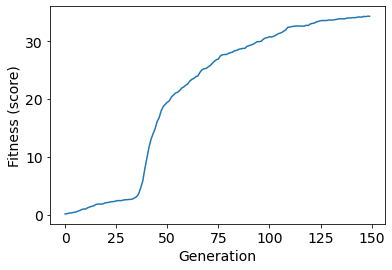

In [118]:
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=14)

fig, ax1 = plt.subplots()
line1 = ax1.plot(gen, avgs_score)
ax1.set_xlabel("Generation")
ax1.set_ylabel("Fitness (score)")

Text(0, 0.5, 'Fitness (timestamp)')

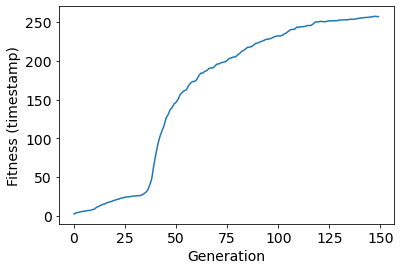

In [119]:
fig2, ax2 = plt.subplots()
line2 = ax2.plot(gen, avgs_timestep)
ax2.set_xlabel("Generation")
ax2.set_ylabel("Fitness (timestamp)")

In [120]:
if not HEADLESS:
    display = DisplayGame(XSIZE,YSIZE)

Below is what you would use for your evaluation. You would also use it to display your final (pickled and loaded) solution, with headless = False.

If you have run without headless (i.e. with the display) you will need to reset your kernel to run again. This appears to be an IPython issue with Turtle, but if you have a way to deal with that, do please let me know. You will probable only want to run it one-at-a-time anyway.

In [121]:
bestInd = tools.selBest(pop, 1)[0]

In [122]:
myNet.setWeightsLinear(bestInd)

In [123]:
run_game(display,myNet,snake_game, headless=HEADLESS)

(24, 141)

In [124]:
turtle.done()


In [125]:
turtle.bye()

Terminator: 

In [127]:
import pickle

In [130]:
file = open('best.pckl', 'wb')

In [131]:
pickle.dump(myNet,file)

AttributeError: Can't pickle local object 'MLP.__init__.<locals>.<lambda>'